In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/Colab Notebooks/summarization')
print(os.listdir())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content
['glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.50d.txt', 'summ', 'dailymail.tgz', 'cnn.tgz', 'data_read_test.ipynb', 'PrepareInput.ipynb', 'glove.6B.300d.txt', 'sent', 'testcode.ipynb', 'summ2', 's2s.h5', 'model.ipynb']


In [2]:
import os
import numpy as np
import pandas as pd
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import keras
orig = os.getcwd()
print(orig)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15377469079644100594
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10391440037780190724
physical_device_desc: "device: XLA_CPU device"
]
/content/drive/My Drive/Colab Notebooks/summarization


Using TensorFlow backend.


In [0]:
#Loading Data and Preparing vocab
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=sys.maxsize,filters ='', lower=False, oov_token = '<OOV>')

In [4]:
print(dir(tokenizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']


In [35]:
#Initializing tokenizer for Vocabulary
data1 = open('sent').readlines()
data2 = open('summ2').readlines()

tokenizer.fit_on_texts(data1)
tokenizer.fit_on_texts(data2)

print("No. of articles and summ",len(data2),len(data1))

dictionary = tokenizer.word_index
word2idx = {}
idx2word = {}
num_encoder_tokens = len(tokenizer.word_index)+1
num_decoder_tokens = len(tokenizer.word_index)+1
for k, v in dictionary.items():
    word2idx[k] = v
    idx2word[v] = k

No. of articles and summ 92454 92454


In [0]:
#Encoding data to integers
sent = tokenizer.texts_to_sequences(data1)
summ = tokenizer.texts_to_sequences(data2)

In [7]:
#padding sequences
#Finding the maximum sequence length
MAX_INPUT_LENGTH = max(len(i.split()) for i in data1)
print(MAX_INPUT_LENGTH)
MAX_TARGET_LENGTH = max(len(j.split()) for j in data2)
print(MAX_TARGET_LENGTH)
padded_sent = pad_sequences(sent, maxlen = MAX_INPUT_LENGTH,padding = 'post')
padded_summ = pad_sequences(summ, maxlen = MAX_TARGET_LENGTH,padding = 'post')
print(padded_sent.shape,padded_summ.shape,type(padded_sent))

2009
112
(92454, 2009) (92454, 112) <class 'numpy.ndarray'>


In [8]:
#preparing training data
encoder_input_data = padded_sent.copy()
decoder_input_data = padded_summ.copy()
# print(decoder_input_data[0],decoder_input_data[1])
decoder_target_data  = np.roll(decoder_input_data, -1, axis = -1)
decoder_target_data[:,-1] = 0

# encoder_input_data.reshape(-1,1,MAX_INPUT_LENGTH)
# decoder_input_data = decoder_input_data.reshape(-1,1,MAX_TARGET_LENGTH)
decoder_target_data = decoder_target_data.reshape(-1,MAX_TARGET_LENGTH,1)
# encoder_input_data = tf.one_hot(encoder_input_data, len(tokenizer.word_index))
# decoder_input_data = tf.one_hot(decoder_input_data, len(tokenizer.word_index))
# decoder_target_data = tf.one_hot(decoder_target_data, len(tokenizer.word_index))
print(encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape)

# print(decoder_input_data[0],decoder_target_data[0])

(92454, 2009) (92454, 112) (92454, 112, 1)


In [0]:
# Preparing GloVe
EMBEDDING_DIM = 300
embeddings_index = {}
f = open(os.path.join('', 'glove.6B.{}d.txt'.format(EMBEDDING_DIM)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [46]:
"fishtailed" in embeddings_index

True

In [11]:
#Embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM),dtype='float32')
for word,i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(348009, 300)


In [0]:
#Creating the Bidirectional model
from keras.layers import Embedding
from keras.layers import Dense, LSTM, Input, concatenate
from keras.models import Model
batch_size = 32
epochs = 10
HIDDEN_UNITS_ENC = 256
num_samples = 10000

In [0]:
encoder_inputs = Input(shape=(MAX_INPUT_LENGTH,), name='encoder_inputs')
embedding_layer = Embedding(num_encoder_tokens, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_INPUT_LENGTH, trainable=False, name='embedding_layer')

encoder_rnn = LSTM(units=HIDDEN_UNITS_ENC, return_state=True, dropout=0.5, recurrent_dropout=0.5,name='encoder_lstm')
encoder_output, state_h_f, state_c_f = encoder_rnn(embedding_layer(encoder_inputs))
encoder_rnn2 = LSTM(units=HIDDEN_UNITS_ENC, return_state=True, dropout=0.5, recurrent_dropout=0.5,
go_backwards=True,name='encoder_lstm_backward')
encoder_output, state_h_b, state_c_b = encoder_rnn2(embedding_layer(encoder_inputs))

state_h = concatenate([state_h_f, state_h_b])
state_c = concatenate([state_c_f, state_c_b])

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,), name='decoder_inputs')
embedding_layer = Embedding(num_decoder_tokens, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False, name='emb_2')
decoder_lstm = LSTM(HIDDEN_UNITS_ENC * 2, return_sequences=True, return_state=True, dropout=0.5,
recurrent_dropout=0.5, name='decoder_lstm')
decoder_outputs, state_h, state_c = decoder_lstm(embedding_layer(decoder_inputs), initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 2009)         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 2009, 300)    104402700   encoder_inputs[0][0]             
                                                                 encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 219648      embedding_layer[0][0]      

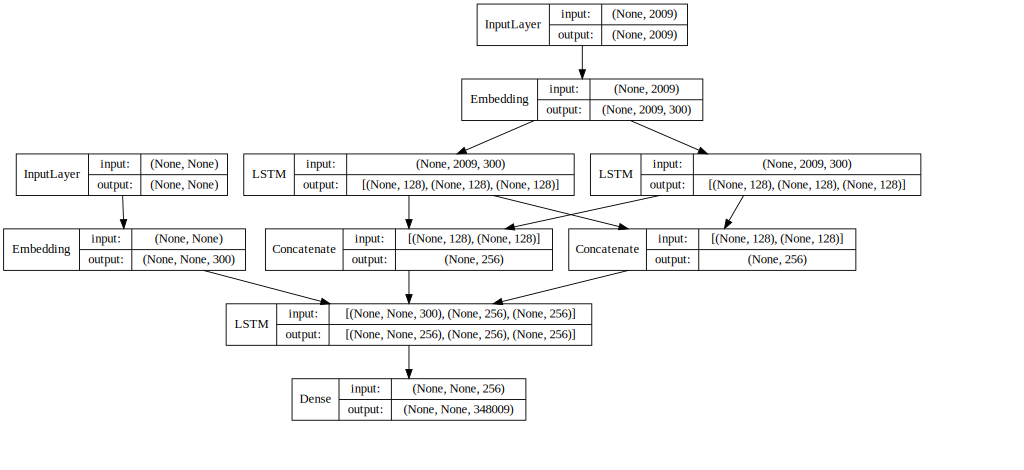

In [37]:
print(model.summary())
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB',dpi=65).create(prog='dot', format='svg'))

In [16]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size = batch_size, epochs = epochs,validation_split=0.9)
model.save('s2s.h5')

"model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])\nmodel.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size = batch_size, epochs = epochs,validation_split=0.9)\nmodel.save('s2s.h5')"

In [0]:
from keras.models import load_model
model = load_model('s2s.h5')

In [0]:
#inference step
encoder_model = Model(encoder_inputs, encoder_states)
# encoder_model.summary()

decoder_state_input_h = Input(shape = (HIDDEN_UNITS_ENC*2,))
decoder_state_input_c = Input(shape = (HIDDEN_UNITS_ENC*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_output, state_h, state_c = decoder_lstm(embedding_layer(decoder_inputs), initial_state = decoder_states_inputs)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_output)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
emb_2 (Embedding)               (None, None, 300)    104402700   decoder_inputs[0][0]             
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

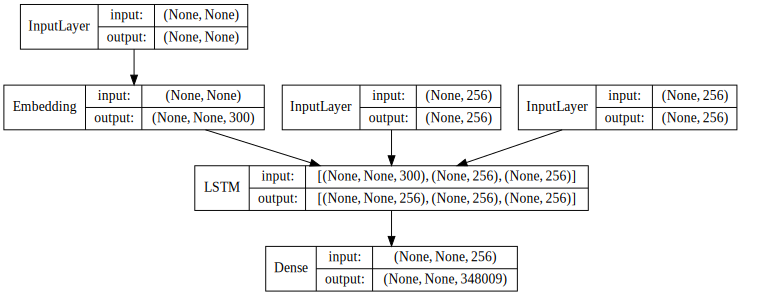

In [40]:
decoder_model.summary()
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(decoder_model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB',dpi = 70).create(prog='dot', format='svg'))

In [0]:
#decoding sequences
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tokenizer.word_index["<BOS>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0,0])
        sampled_char = idx2word[sampled_token_index]
        # print(sampled_token_index,end=" ")
        decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<EOS>' or
           len(decoded_sentence) > MAX_TARGET_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [44]:
seq = 1
input_seq = encoder_input_data[seq:seq+1]
decoded_sentence = decode_sequence(input_seq)
print('-')
print('Article:', data1[seq].strip())
print('Actual Summary:', data2[seq][5:-5])
print('Predicted Summary:', decoded_sentence)

-
Article: brunei has become the first east asian country to adopt sharia law despite widespread condemnation from international human rights groups . the islamic criminal law is set to include punishments such as flogging dismemberment and death by stoning for crimes such as rape adultery and sodomy . the religious laws will operate alongside the existing civil penal code . during a ceremony wednesday morning the sultan of brunei hassanal bolkiah announced the commencement of the first phase of the shariabased penal code according to the government 's official website . the oilrich kingdom located on the island of borneo has a population of just 412 000 people . the country already follows a more conservative islamic rule than neighboring muslimdominated countries like indonesia and malaysia and has implemented strict religiouslymotivated laws such as the banning of the sale of alcohol . stringent laws in response to the new set of laws human rights group amnesty international said th